# Valuation Logic

## The valuation Strategy

Our goal is to calculate the Intrinsic Value of Alphabet by segmenting its revenue streams and applying different "AI Sensitivity" factors to each.

### 1. Revenue Segmentation & Driver Logic

We will build the model using these specific levers based on the above narrative:

Search (The Core): * Volume: Driven by "Informational Query Share." We'll model the 25% volume drop predicted by Gartner.

CTR (Click-Through Rate): We'll use the -68% "Meteor Strike" variable for AIO-impacted queries.

CPC (Cost Per Click): We'll model the "Amazon Effect"—initially high (fixed budgets) but decaying as advertisers realize the "Incrementality" (as Amazon did).

CVR (Conversion Rate): The 4–5x multiplier noted as the "Redeeming Factor."

GCP (The Growth Engine): * Revenue growth driven by AI Inference.

Margin Expansion: Stepping up from 23.7% toward AWS's ~35% over 5 years.

YouTube & Subscriptions: * Standard high-growth modeling (15–20%).



### 2. Scenario Architecture

We will create three distinct paths for the Python model to calculate:

The "Structural Decay" (Bear): CPCs drop once advertisers adjust; AI conversion gains don't fully compensate for the 68% CTR loss. I'm aware that in the short term CPC has actually increased, but as I've discussed above, I can't see this being persistent. 

The "High-Intent Pivot" (Base): Google successfully transitions from a "Volume" business to a "Value" business, charging much more for the 5x higher-converting leads.

The "Cloud Alpha" (Bull): Search stabilizes and GCP becomes the primary profit driver by 2030, exceeding AWS margins due to TPU efficiency.

I'll also do a monte-carlo analysis of all the in-between cases.

### 3. Monopoly decay premium

In the Bear case - which is my view - I'll inflate the WACC by 1% to account for the regulatory and pressure on the company's monopoly position. This is a risk that's hard to model in any particular part of the cashflows so it makes sense to account for this risk by inflating the WACC - because a dying monopoly should not be discounted at 8%.

I know this is arbitrary, so I'll also use a monte carlo simulation to visualise it.

# The code

WACC Calculations

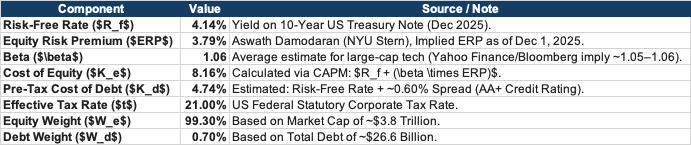

I'll use 8.13% as the WACC

$$WACC = (W_e \times K_e) + (W_d \times After\text{-}Tax K_d)$$$$WACC = (0.993 \times 8.16\%) + (0.007 \times 3.74\%)$$$$WACC = 8.10\% + 0.03\%$$$$WACC \approx 8.13\%$$

### Parameters in Code

In [1]:
import pandas as pd
import numpy as np

# --- 1. THE FLAT PARAMETER DICTIONARY ---
# This dictionary represents the "Base Case" but is built to be mutated.

base_params = {
    # --- REVENUE BASELINES (Dec 2025) ---
    'search_rev_base': 220000,
    'gcp_rev_base': 58000,
    'yt_rev_base': 40000,
    'adsense_rev_base': 29000,
    
    # --- SEARCH NARRATIVE DRIVERS ---
    'search_vol_growth': 0.00,      # Annual volume growth
    'cpc_shock': 0.07,              # Year 1 immediate decrease (7%)
    'cpc_decay_annual': 0.02,       # CPC decays each year by this amount
    'ctr_multiplier': 0.32,         # (1 - 0.68) -> Users click 68% less
    'cvr_multiplier': 4.5,          # Users convert 4.5x better on remaining clicks
    
    # --- CLOUD (GCP) DYNAMICS ---
    'gcp_growth_start': 0.33,       # Year 1 growth
    'gcp_growth_end': 0.18,         # Year 10 growth
    'gcp_margin_start': 0.237,      # Current margin
    'gcp_margin_target': 0.33,      # AWS/Azure maturity level
    
    # --- OTHER SEGMENTS ---
    'adsense_growth': -0.02,
    'yt_growth': 0.20,
    
    # --- PROFITABILITY & VALUATION ---
    'ads_business_margin': 0.32,    # Margin for Search/YT/Adsense (ex-Cloud)
    'tax_rate': 0.15,
    'wacc': 0.0865,
    'terminal_growth': 0.035,
    
    # --- DYNAMIC CAPEX ---
    'capex_intensity_start': 0.24,  # High spend for AI (Years 1-3)
    'capex_intensity_end': 0.14,    # Maintenance mode (Year 10)
    
    # --- BALANCE SHEET ---
    'net_cash': 70000,
    'shares_outstanding': 12070
}

In [2]:
bear_params = {
    **base_params,
    # Search
    'search_vol_growth': -0.05,
    'ctr_multiplier': 0.32,   # (1 - 0.68) -> Users click 68% less
    'cpc_shock': 0.15, # Year 1 immediate decrease (15%) - the amazon effect
    'cvr_multiplier': 4, # Users convert 4x better on remaining clicks

    # GCP
    'gcp_growth_start': 0.33,
    'gcp_growth_end': 0.18,
    'gcp_margin_target': 0.32,

    # Other segments
    'adsense_growth': -0.05,
    'yt_growth': 0.18,

    # Valuation
    'wacc': 0.0913,
    'terminal_growth': 0.035,
}

In [3]:
bull_params = {
    **base_params,
    # Search
    'search_vol_growth': 0.02,
    'ctr_multiplier': 0.32,  # (1 - 0.68) -> Users click 68% less
    'cpc_shock': 0.00,
    'cvr_multiplier': 5.0,

    # GCP
    'gcp_growth_start': 0.33,
    'gcp_growth_end': 0.18,
    'gcp_margin_target': 0.36,

    # Other segments
    'adsense_growth': -0.02,
    'yt_growth': 0.20,

    # Valuation
    'wacc': 0.0813,
    'terminal_growth': 0.035,
}

### Valuation Model

In [4]:
def run_valuation_model(params):
    """
    Accepts a dictionary of assumptions. 
    Returns a dictionary containing the Share Price and the DataFrame of cash flows.
    """
    years = 10
    results = []
    
    # Initialize rolling variables
    current_gcp_rev = params['gcp_rev_base']
    
    for y in range(1, years + 1):
        
        # --- A. REVENUE ENGINE ---
        
        # 1. SEARCH: The "Narrative" Logic
        # Volume grows normally
        vol_factor = (1 + params['search_vol_growth'])**y 
        
        # CPC takes a shock in Y1, then decays annually (The Amazon Shock)
        # Logic: (1 - Initial Shock) * (1 - Decay)^(Year-1)
        cpc_factor = (1 - params['cpc_shock']) * ((1 - params['cpc_decay_annual']) ** (y - 1))
        
        # Revenue = Base * Vol * CPC_Trend * CTR_Change * CVR_Change
        search_rev = (params['search_rev_base'] * vol_factor * cpc_factor * params['ctr_multiplier'] * params['cvr_multiplier'])

        # 2. GCP: Interpolated Growth
        # Linearly decay growth rate from Start to End
        current_growth = params['gcp_growth_start'] - ((params['gcp_growth_start'] - params['gcp_growth_end']) * (y/years))
        current_gcp_rev *= (1 + current_growth)
        
        # 3. OTHERS
        adsense_rev = params['adsense_rev_base'] * (1 + params['adsense_growth'])**y
        yt_rev = params['yt_rev_base'] * (1 + params['yt_growth'])**y
        
        total_rev = search_rev + current_gcp_rev + adsense_rev + yt_rev
        
        # --- B. PROFITABILITY ENGINE ---
        
        # 1. GCP Op Income (Interpolate Margin 23% -> 36%)
        current_gcp_margin = params['gcp_margin_start'] + ((params['gcp_margin_target'] - params['gcp_margin_start']) * (y/years))
        gcp_op_inc = current_gcp_rev * current_gcp_margin
        
        # 2. Advertising Op Income (Search + YT + Adsense)
        # We apply the ad margin specifically to ad revenue, not Cloud revenue
        ad_rev_total = search_rev + yt_rev + adsense_rev
        ad_op_inc = ad_rev_total * params['ads_business_margin']
        
        # 3. Total Operating Income
        total_op_inc = gcp_op_inc + ad_op_inc
        
        # --- C. CASH FLOW ENGINE ---
        
        after_tax_profit = total_op_inc * (1 - params['tax_rate'])
        
        # Dynamic CapEx: High in Y1-3, decays to Y10
        if y <= 3:
            capex_ratio = params['capex_intensity_start']
        else:
            # Decay slope
            remaining_years = years - 3
            decay_step = (params['capex_intensity_start'] - params['capex_intensity_end']) / remaining_years
            capex_ratio = params['capex_intensity_start'] - (decay_step * (y - 3))
            
        capex = total_rev * capex_ratio
        
        # Add-backs
        dna = capex * 0.70          # Proxied as % of CapEx
        sbc = total_rev * 0.05      # Proxied as % of Rev
        
        fcf = after_tax_profit + dna + sbc - capex
        
        # Discount Factor
        discount_factor = (1 + params['wacc']) ** y
        pv_fcf = fcf / discount_factor
        
        results.append({
            'Year': 2025 + y,
            'Total_Rev': total_rev,
            'Search_Rev': search_rev,
            'GCP_Rev': current_gcp_rev,
            'Op_Inc': total_op_inc,
            'FCF': fcf,
            'PV_FCF': pv_fcf
        })

    df = pd.DataFrame(results)
    
    # --- D. VALUATION ---
    
    # Sum of PV of Cash Flows (Years 1-10)
    sum_pv_fcf = df['PV_FCF'].sum()
    
    # Terminal Value (Gordon Growth)
    fcf_y10 = df.iloc[-1]['FCF']
    terminal_value = (fcf_y10 * (1 + params['terminal_growth'])) / (params['wacc'] - params['terminal_growth'])
    
    # Discount TV to Present
    pv_terminal_value = terminal_value / ((1 + params['wacc']) ** years)
    
    # Equity Value
    enterprise_value = sum_pv_fcf + pv_terminal_value
    equity_value = enterprise_value + params['net_cash']
    share_price = equity_value / params['shares_outstanding']
    
    return share_price, df


### Bridge in Valuation

In [5]:
# --- 3. CALCULATE THE BRIDGE ---
import nbformat

def get_valuation_delta(start_params, changes_dict):
    """Calculates price impact of applying specific changes."""
    price_start = run_valuation_model(start_params)[0] 
    
    new_params = start_params.copy()
    new_params.update(changes_dict)
    
    price_end = run_valuation_model(new_params)[0]
    return price_end - price_start, new_params

waterfall_data = []

groups = {
    "Search Physics": ['search_vol_growth', 'cpc_shock', 'ctr_multiplier', 'cvr_multiplier', 'cpc_decay_annual'],
    "Cloud (GCP)":    ['gcp_growth_start', 'gcp_growth_end', 'gcp_margin_target'], # Added margin here
    "Other Segments": ['adsense_growth', 'yt_growth'],
    "Macro (WACC)":   ['wacc', 'terminal_growth']
}



# ==========================================
# PART 1: BEAR -> BASE BRIDGE
# ==========================================

# A. Bear Baseline
bear_price = run_valuation_model(bear_params)[0]
waterfall_data.append({"label": "Bear Case", "value": bear_price, "type": "absolute"})

current_params = bear_params.copy()

# Step 1: Search Physics (Bear -> Base)
search_diffs = {k: base_params[k] for k in groups['Search Physics'] if base_params[k] != current_params[k]}
if search_diffs:
    delta, current_params = get_valuation_delta(current_params, search_diffs)
    waterfall_data.append({"label": "Search Recovery", "value": delta, "type": "relative"})

# Step 2: Cloud (GCP) (Bear -> Base)
gcp_diffs = {k: base_params[k] for k in groups['Cloud (GCP)'] if base_params[k] != current_params[k]}
if gcp_diffs:
    delta, current_params = get_valuation_delta(current_params, gcp_diffs)
    waterfall_data.append({"label": "Cloud (GCP)", "value": delta, "type": "relative"})

# Step 3: Other Segments (Bear -> Base)
other_diffs = {k: base_params[k] for k in groups['Other Segments'] if base_params[k] != current_params[k]}
if other_diffs:
    delta, current_params = get_valuation_delta(current_params, other_diffs)
    waterfall_data.append({"label": "Other Segments", "value": delta, "type": "relative"})

# Step 4: Macro/WACC (Bear -> Base)
wacc_diffs = {k: base_params[k] for k in groups['Macro (WACC)'] if base_params[k] != current_params[k]}
if wacc_diffs:
    delta, current_params = get_valuation_delta(current_params, wacc_diffs)
    waterfall_data.append({"label": "Multiple Expansion", "value": delta, "type": "relative"})

# ==========================================
# PART 2: BASE BASELINE
# ==========================================

base_price = run_valuation_model(base_params)[0]
waterfall_data.append({"label": "Base Case", "value": base_price, "type": "absolute"})

# ==========================================
# PART 3: BASE -> BULL BRIDGE
# ==========================================

current_params = base_params.copy()

# Step 1: Search Physics (Base -> Bull)
search_diffs_bull = {k: bull_params[k] for k in groups['Search Physics'] if bull_params[k] != current_params[k]}
if search_diffs_bull:
    delta, current_params = get_valuation_delta(current_params, search_diffs_bull)
    waterfall_data.append({"label": "Search Outperf.", "value": delta, "type": "relative"})

# Step 2: Cloud (GCP) (Base -> Bull)
gcp_diffs_bull = {k: bull_params[k] for k in groups['Cloud (GCP)'] if bull_params[k] != current_params[k]}
if gcp_diffs_bull:
    delta, current_params = get_valuation_delta(current_params, gcp_diffs_bull)
    waterfall_data.append({"label": "Cloud Acceleration", "value": delta, "type": "relative"})

# Step 3: Other Segments (Base -> Bull)
other_diffs_bull = {k: bull_params[k] for k in groups['Other Segments'] if bull_params[k] != current_params[k]}
if other_diffs_bull:
    delta, current_params = get_valuation_delta(current_params, other_diffs_bull)
    waterfall_data.append({"label": "Other Segments", "value": delta, "type": "relative"})

# Step 4: Macro/WACC (Base -> Bull)
wacc_diffs_bull = {k: bull_params[k] for k in groups['Macro (WACC)'] if bull_params[k] != current_params[k]}
if wacc_diffs_bull:
    delta, current_params = get_valuation_delta(current_params, wacc_diffs_bull)
    waterfall_data.append({"label": "WACC Compression", "value": delta, "type": "relative"})

# ==========================================
# PART 4: BULL BASELINE
# ==========================================

bull_price = run_valuation_model(bull_params)[0]
waterfall_data.append({"label": "Bull Case", "value": bull_price, "type": "absolute"})

# --- DEBUG PRINT ---
print(f"Bear: ${bear_price:.2f}")
print(f"Base: ${base_price:.2f}")
print(f"Bull: ${bull_price:.2f}")

# --- 4. PLOTTING ---
import plotly.graph_objects as go

fig = go.Figure(go.Waterfall(
    name = "Valuation Bridge",
    orientation = "v",
    measure = [x['type'] for x in waterfall_data],
    x = [x['label'] for x in waterfall_data],
    textposition = "outside",
    text = [f"${x['value']:.0f}" if x['type'] == 'absolute' else f"{'+' if x['value'] > 0 else ''}{x['value']:.0f}" for x in waterfall_data],
    y = [x['value'] for x in waterfall_data],
    connector = {"line": {"color": "rgb(63, 63, 63)"}},
    decreasing = {"marker": {"color": "#FF9DA7"}},
    increasing = {"marker": {"color": "#59C16C"}},
    totals = {"marker": {"color": "#4C78A8"}}
))

fig.update_layout(
    title = "Valuation Sensitivity: Bear to Base to Bull",
    showlegend = False,
    waterfallgap = 0.3,
    # Adding padding to Y-axis so labels fit
    yaxis=dict(title="Share Price ($)", range=[0, bull_price * 1.2]) 
)

fig.show()

Bear: $230.50
Base: $308.81
Bull: $399.68


In [6]:
import pandas as pd
import plotly.graph_objects as go

# --- 1. DEFINE SENSITIVITIES ---
# Define how much we want to shock each variable to test sensitivity.
# (param_name, down_shock, up_shock, label)
# Note: For WACC, a "Higher" input is "Bad" for price, but the logic handles the min/max price automatically.

sensitivity_config = [
    # (Parameter Name, Change, Label Description)
    ('wacc', 0.01, 'WACC (+/- 1.0%)'),
    ('terminal_growth', 0.01, 'Terminal Growth (+/- 1.0%)'),
    ('search_vol_growth', 0.02, 'Search Vol Growth (+/- 2.0%)'),
    ('cpc_shock', 0.15, 'CPC Shock (+/- 15%)'),
    ('gcp_margin_target', 0.05, 'GCP Target Margin (+/- 5%)'),
    ('ads_business_margin', 0.03, 'Ads Core Margin (+/- 3%)'),
    ('ctr_multiplier', 0.05, 'CTR Multiplier (+/- 0.05)'),
    ('capex_intensity_start', 0.05, 'AI Capex Intensity (+/- 5%)'),
    ('cvr_multiplier', 1.0, 'CVR Multiplier (+/- 1.0x)'),
]

# --- 2. CALCULATE RANGES ---

data = []
base_price = run_valuation_model(base_params)[0]

for param, shock, label in sensitivity_config:
    # 1. Low Input Case
    low_params = base_params.copy()
    low_params[param] = base_params[param] - shock
    price_low_input = run_valuation_model(low_params)[0]
    
    # 2. High Input Case
    high_params = base_params.copy()
    high_params[param] = base_params[param] + shock
    price_high_input = run_valuation_model(high_params)[0]
    
    # 3. Determine which is the Upside vs Downside price
    # (Because higher WACC = Lower Price, we sort them by price result, not input direction)
    min_price = min(price_low_input, price_high_input)
    max_price = max(price_low_input, price_high_input)
    
    # Calculate variation from base
    downside = min_price - base_price
    upside = max_price - base_price
    total_swing = max_price - min_price
    
    data.append({
        'Label': label,
        'Min_Price': min_price,
        'Max_Price': max_price,
        'Downside': downside,
        'Upside': upside,
        'Swing': total_swing
    })

# Convert to DF and Sort by widest swing (Tornado shape)
df_tornado = pd.DataFrame(data).sort_values(by='Swing', ascending=True)

# --- 3. PLOT TORNADO CHART ---

fig = go.Figure()

# Trace 1: Downside Bars (Red)
# We use 'base' to start the bar at the Base Price
fig.add_trace(go.Bar(
    y=df_tornado['Label'],
    x=df_tornado['Downside'],
    base=base_price,
    orientation='h',
    name='Downside',
    marker=dict(color='#d62728'), # Red
    text=[f"${x:.2f}" for x in df_tornado['Min_Price']],
    textposition='auto'
))

# Trace 2: Upside Bars (Green)
fig.add_trace(go.Bar(
    y=df_tornado['Label'],
    x=df_tornado['Upside'],
    base=base_price,
    orientation='h',
    name='Upside',
    marker=dict(color='#2ca02c'), # Green
    text=[f"${x:.2f}" for x in df_tornado['Max_Price']],
    textposition='auto'
))

# Update Layout
fig.update_layout(
    title=f"Sensitivity Tornado Chart (Base Price: ${base_price:.2f})",
    barmode='overlay', # Overlay allows them to center on the axis cleanly
    xaxis=dict(title="Share Price ($)"),
    yaxis=dict(title="Parameter Sensitivity"),
    showlegend=False,
    height=600,
    shapes=[
        # Add a vertical line for the Base Price
        dict(
            type="line",
            x0=base_price,
            y0=-1,
            x1=base_price,
            y1=len(df_tornado),
            line=dict(color="black", width=2, dash="dash"),
        )
    ]
)

fig.show()

In [7]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# --- 1. DEFINE SIMULATION PARAMETERS ---
SIMULATIONS = 5000  # Number of runs
np.random.seed(42)  # For reproducibility

# Helper to generate distributions based on your 3 scenarios
def get_triangular_dist(param_name):
    """
    Creates a distribution using Bear as Min, Base as Mode, Bull as Max.
    Handles cases where Bear > Bull (like WACC) automatically.
    """
    val1 = bear_params[param_name]
    val2 = base_params[param_name]
    val3 = bull_params[param_name]
    
    mn = min(val1, val2, val3)
    mx = max(val1, val2, val3)
    mode = val2 # Base case is always the peak (mode)
    
    # If all 3 are identical, return constant array to avoid errors
    if mn == mx:
        return np.full(SIMULATIONS, mode)
        
    return np.random.triangular(left=mn, mode=mode, right=mx, size=SIMULATIONS)

# --- 2. GENERATE INPUTS ---
# We flex only the variables that actually differ between your scenarios
sim_data = {
    # Valuation / Macro
    'wacc': get_triangular_dist('wacc'),
    
    # Search Physics
    'search_vol_growth': get_triangular_dist('search_vol_growth'),
    'cpc_shock': get_triangular_dist('cpc_shock'),
    'ctr_multiplier': get_triangular_dist('ctr_multiplier'),
    'cvr_multiplier': get_triangular_dist('cvr_multiplier'),
    
    # Segments
    'adsense_growth': get_triangular_dist('adsense_growth'),
    
    # Note: Variables like Tax Rate or Shares are constant across your 3 scenarios,
    # so we don't need to simulate them unless you want to add artificial variance.
}

# --- 3. RUN SIMULATION ---
results = []

print(f"Running {SIMULATIONS} simulations...")

for i in range(SIMULATIONS):
    # Start with base params as the template
    iteration_params = base_params.copy()
    
    # Overwrite with the specific simulated values for this run
    for key, values in sim_data.items():
        iteration_params[key] = values[i]
        
    # Run Model
    # Note: We use [0] to grab just the price from your function return
    share_price = run_valuation_model(iteration_params)[0]
    results.append(share_price)

# --- 4. ANALYZE RESULTS ---
sim_results = np.array(results)

mean_price = np.mean(sim_results)
median_price = np.median(sim_results)
p10 = np.percentile(sim_results, 10) # 10% chance it's lower than this (Downside Risk)
p90 = np.percentile(sim_results, 90) # 10% chance it's higher than this (Upside Potential)

print(f"--- Results ---")
print(f"Mean Price:   ${mean_price:.2f}")
print(f"Median Price: ${median_price:.2f}")
print(f"10th % (Bearish boundary): ${p10:.2f}")
print(f"90th % (Bullish boundary): ${p90:.2f}")

# --- 5. PLOT HISTOGRAM ---
fig = px.histogram(
    x=sim_results, 
    nbins=60, 
    title="Monte Carlo Simulation: Valuation Distribution (5,000 Runs)",
    labels={'x': 'Share Price ($)'},
    opacity=0.75,
    color_discrete_sequence=['#4C78A8']
)

# Add vertical lines for key statistics
fig.add_vline(x=mean_price, line_width=3, line_dash="dash", line_color="black", annotation_text=f"Mean: ${mean_price:.0f}")
fig.add_vline(x=p10, line_width=2, line_dash="dot", line_color="#d62728", annotation_text=f"P10: ${p10:.0f}")
fig.add_vline(x=p90, line_width=2, line_dash="dot", line_color="#2ca02c", annotation_text=f"P90: ${p90:.0f}")

# Clean up layout
fig.update_layout(
    yaxis_title="Frequency",
    bargap=0.1,
    showlegend=False
)

fig.show()

Running 5000 simulations...
--- Results ---
Mean Price:   $303.30
Median Price: $302.58
10th % (Bearish boundary): $281.59
90th % (Bullish boundary): $325.81


The Monte-Carlo simulation shows the downside risks inherrent in the business. There is more densite left of the mean than the right.

In [8]:
import pandas as pd
import plotly.graph_objects as go

# --- 1. MANUAL INPUTS ---
# Update these numbers manually when you want to refresh the chart
TICKER = "GOOGL"

# Financial Data
current_price = 313.00
eps_ttm = 10.13

# Valuation Ranges (Low, High)
range_52wk = (140.00, 328.00)
range_analyst = (236.00, 385.00)
range_pe_history = (19.23, 31.00) # Historical PE Ratio
range_pe_peers = (29.36, 47.00)   # Peer PE Ratio (Meta, MSFT, Amzn)
range_dcf = (282.00, 326.00)      # From your Monte Carlo (p10, p90)

# --- 2. CALCULATE IMPLIED PRICES ---
# We calculate the share price implied by the PE multiples
hist_implied_low = range_pe_history[0] * eps_ttm
hist_implied_high = range_pe_history[1] * eps_ttm

peer_implied_low = range_pe_peers[0] * eps_ttm
peer_implied_high = range_pe_peers[1] * eps_ttm

# --- 3. PREPARE DATA FOR PLOTTING ---
plot_data = [
    {
        'Label': '52-Week Range', 
        'Min': range_52wk[0], 
        'Max': range_52wk[1], 
        'Category': 'Market'
    },
    {
        'Label': 'Analyst Price Targets', 
        'Min': range_analyst[0], 
        'Max': range_analyst[1], 
        'Category': 'Market'
    },
    {
        'Label': f"Hist. Multiples ({range_pe_history[0]}x - {range_pe_history[1]}x)", 
        'Min': hist_implied_low, 
        'Max': hist_implied_high, 
        'Category': 'Relative Valuation'
    },
    {
        'Label': f"Peer Comps ({range_pe_peers[0]}x - {range_pe_peers[1]}x)", 
        'Min': peer_implied_low, 
        'Max': peer_implied_high, 
        'Category': 'Relative Valuation'
    },
    {
        'Label': 'DCF Model (Monte Carlo)', 
        'Min': range_dcf[0], 
        'Max': range_dcf[1], 
        'Category': 'Intrinsic Value'
    }
]

df_football = pd.DataFrame(plot_data)

# --- 4. PLOT CHART ---
fig = go.Figure()

for i, row in df_football.iterrows():
    bar_length = row['Max'] - row['Min']
    
    # Color Logic
    if row['Category'] == 'Market': 
        color = '#A0CBE8' # Light Blue
    elif row['Category'] == 'Relative Valuation': 
        color = '#F28E2B' # Orange
    else: 
        color = '#59C16C' # Green

    # Draw the floating bar
    fig.add_trace(go.Bar(
        y=[row['Label']], 
        x=[bar_length], 
        base=[row['Min']],
        orientation='h', 
        marker=dict(color=color, opacity=0.8),
        hovertemplate=f"<b>{row['Label']}</b><br>Range: ${row['Min']:.2f} - ${row['Max']:.2f}<extra></extra>"
    ))
    
    # Add text labels on the left and right of the bars
    fig.add_trace(go.Scatter(
        y=[row['Label']], x=[row['Min'] - 5], mode='text', 
        text=[f"${row['Min']:.0f}"], textposition="middle left", 
        showlegend=False, textfont=dict(color='black', size=11)
    ))
    fig.add_trace(go.Scatter(
        y=[row['Label']], x=[row['Max'] + 5], mode='text', 
        text=[f"${row['Max']:.0f}"], textposition="middle right", 
        showlegend=False, textfont=dict(color='black', size=11)
    ))

# Add the vertical line for Current Price
fig.add_vline(
    x=current_price, 
    line_width=2, 
    line_dash="dash", 
    line_color="red", 
    annotation_text=f"Current: ${current_price:.2f}", 
    annotation_position="top right"
)

# Final Layout Polish
fig.update_layout(
    title=f"Valuation Football Field: {TICKER}", 
    showlegend=False, 
    height=500, 
    xaxis=dict(title="Share Price ($)", zeroline=False, gridcolor='lightgray'), 
    yaxis=dict(title="", showgrid=False), 
    plot_bgcolor='white'
)

fig.show()